In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *


In [3]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [4]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [5]:
from PIL import Image

def callingFunc(i):
    x1 = Image.open(
        r'..\stormdata\Storm Classification\Storm\storm'+str(i)+'.jpg').convert('L');
    y1 = np.asarray(x1.getdata(), dtype=np.float64).reshape((x1.size[1], x1.size[0]));

    y_dat1 = np.asarray(y1, dtype=np.uint8);
    y_dat1_Im = transforms.ToTensor()(y_dat1).unsqueeze_(0);
    
    
    return y_dat1_Im[0]

def callingFuncN(i):
    x1 = Image.open(
        r'..\stormdata\Storm Classification\No storm\No_storm'+str(i)+'.jpg').convert('L');
    y1 = np.asarray(x1.getdata(), dtype=np.float64).reshape((x1.size[1], x1.size[0]));

    y_dat1 = np.asarray(y1, dtype=np.uint8);
    y_dat1_Im = transforms.ToTensor()(y_dat1).unsqueeze_(0);
    
    
    return y_dat1_Im[0]    

In [6]:
input1 = torch.stack([callingFunc(i+1)[0] for i in range(63)])
input2 = torch.stack([callingFuncN(i+1)[0] for i in range(25)])
input_o = torch.cat([input1,input2])

In [7]:
target1 = torch.Tensor([0]).repeat(63);
target2 = torch.Tensor([1]).repeat(25);
target_o = torch.cat([target1,target2]);

In [13]:

# Leaving only labels 0 and 1 
idx=torch.randperm(88)

dataInput = input_o[idx]
dataTarget = target_o[idx]


train_data = []
for i in range(len(dataInput)):
   train_data.append([dataInput[i], dataTarget[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True)
i1, l1 = next(iter(trainloader))
print(i1.shape)

torch.Size([1, 8, 8])


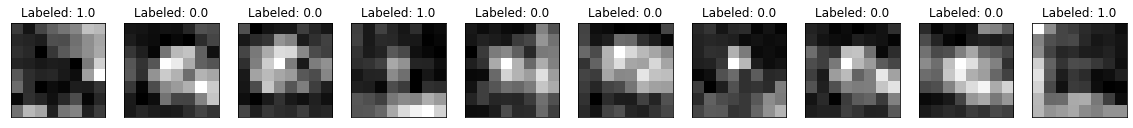

In [15]:
n_samples_show = 10

data_iter = iter(trainloader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(64, 5)
        self.fc2 = nn.Linear(5, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = x.view(-1, 64)            # -> n, 16384
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 120  # -> n, 52142
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [20]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

epochs = 50
loss_list = []




model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target.long())
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

<ipython-input-4-bf16e473ae62>:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [2%]	Loss: -0.7664
Training [4%]	Loss: -0.8360
Training [6%]	Loss: -0.8399
Training [8%]	Loss: -0.8440
Training [10%]	Loss: -0.8483
Training [12%]	Loss: -0.8531
Training [14%]	Loss: -0.8502
Training [16%]	Loss: -0.8515
Training [18%]	Loss: -0.8597
Training [20%]	Loss: -0.8510
Training [22%]	Loss: -0.8565
Training [24%]	Loss: -0.8480
Training [26%]	Loss: -0.8482
Training [28%]	Loss: -0.8532
Training [30%]	Loss: -0.8634
Training [32%]	Loss: -0.8551
Training [34%]	Loss: -0.8498
Training [36%]	Loss: -0.8500
Training [38%]	Loss: -0.8590
Training [40%]	Loss: -0.8470
Training [42%]	Loss: -0.8536
Training [44%]	Loss: -0.8547
Training [46%]	Loss: -0.8569
Training [48%]	Loss: -0.8506
Training [50%]	Loss: -0.8582
Training [52%]	Loss: -0.8640
Training [54%]	Loss: -0.8557
Training [56%]	Loss: -0.8547
Training [58%]	Loss: -0.8632
Training [60%]	Loss: -0.8583
Training [62%]	Loss: -0.8581
Training [64%]	Loss: -0.8552
Training [66%]	Loss: -0.8527
Training [68%]	Loss: -0.8515
Training [70%]	Los

Text(0, 0.5, 'Neg Log Likelihood Loss')

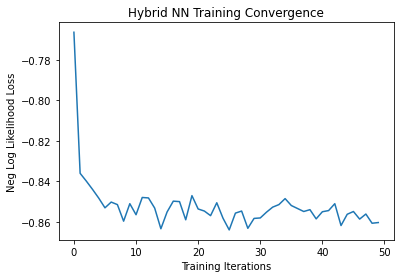

In [21]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [25]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target.long())
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(trainloader) * 100)
        )

Performance on test data:
	Loss: -0.8593
	Accuracy: 86.4%


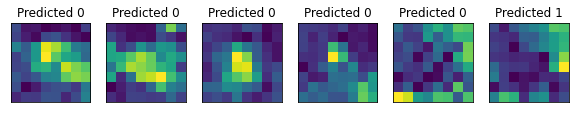

In [26]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()



with torch.no_grad():
    for batch_idx, (data, target) in enumerate(trainloader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), )

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1